<a href="https://colab.research.google.com/github/satuelisa/NLPF/blob/main/NLPF_01_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
install.packages('gutenbergr') # check https://cran.r-project.org/web/packages/gutenbergr/vignettes/intro.html for documentation, this is like using pip in python
library(gutenbergr)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘Rcpp’, ‘triebeard’, ‘urltools’, ‘lazyeval’



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [7]:
mirror <- "http://mirrors.xmission.com/gutenberg/"
book <- gutenberg_download(768, mirror = mirror) # this one is Wuthering Heights

What did we get, actually? We can uyuse *head* and *tail* to look at how it starts and ends.

In [13]:
head(book)
tail(book)

gutenberg_id,text
<int>,<chr>
768,Wuthering Heights
768,
768,by Emily Brontë
768,
768,
768,


gutenberg_id,text
<int>,<chr>
768,still bare.
768,
768,"I lingered round them, under that benign sky: watched the moths"
768,"fluttering among the heath and harebells, listened to the soft wind"
768,"breathing through the grass, and wondered how any one could ever"
768,imagine unquiet slumbers for the sleepers in that quiet earth.


So, we have a... *tibble*? It seems to contain one line of text per row. The textbook points us towards the *tidytext* library to chop this into chapters like we did in Python for *Pride and Prejudice*.

In [14]:
install.packages("tidytext")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [15]:
library(tidytext)
library(dplyr) # should be pre-installed
library(stringr) # as should this

In [55]:
clean <- book %>% mutate(linenumber = row_number(), chapter = cumsum(str_detect(text, regex("^chapter [\\divxlc]", ignore_case = TRUE))))
# that %>% is just the R way to write "forward pipe", much like | in linux
head(clean)
tail(clean)
max(clean$chapter)

gutenberg_id,text,linenumber,chapter
<int>,<chr>,<int>,<int>
768,Wuthering Heights,1,0
768,,2,0
768,by Emily Brontë,3,0
768,,4,0
768,,5,0
768,,6,0


gutenberg_id,text,linenumber,chapter
<int>,<chr>,<int>,<int>
768,still bare.,12337,34
768,,12338,34
768,"I lingered round them, under that benign sky: watched the moths",12339,34
768,"fluttering among the heath and harebells, listened to the soft wind",12340,34
768,"breathing through the grass, and wondered how any one could ever",12341,34
768,imagine unquiet slumbers for the sleepers in that quiet earth.,12342,34


[1] 34

In [18]:
tidy <- clean %>% unnest_tokens(word, text)
head(tidy)
tail(tidy)

gutenberg_id,linenumber,chapter,word
<int>,<int>,<int>,<chr>
768,1,0,wuthering
768,1,0,heights
768,3,0,by
768,3,0,emily
768,3,0,brontë
768,8,1,chapter


gutenberg_id,linenumber,chapter,word
<int>,<int>,<int>,<chr>
768,12342,34,the
768,12342,34,sleepers
768,12342,34,in
768,12342,34,that
768,12342,34,quiet
768,12342,34,earth


Now we can eliminate stop words like we did in Python using NLTK.

In [19]:
data(stop_words)
relevant <- tidy %>% anti_join(stop_words)
head(relevant)
tail(relevant)

Joining, by = "word"


gutenberg_id,linenumber,chapter,word
<int>,<int>,<int>,<chr>
768,1,0,wuthering
768,1,0,heights
768,3,0,emily
768,3,0,brontë
768,8,1,chapter
768,11,1,1801


gutenberg_id,linenumber,chapter,word
<int>,<int>,<int>,<chr>
768,12342,34,imagine
768,12342,34,unquiet
768,12342,34,slumbers
768,12342,34,sleepers
768,12342,34,quiet
768,12342,34,earth


We can access the word frequencies with ease.

word,n
<chr>,<int>
heathcliff,421
linton,346
catherine,336
i’m,192
i’ll,189
master,185


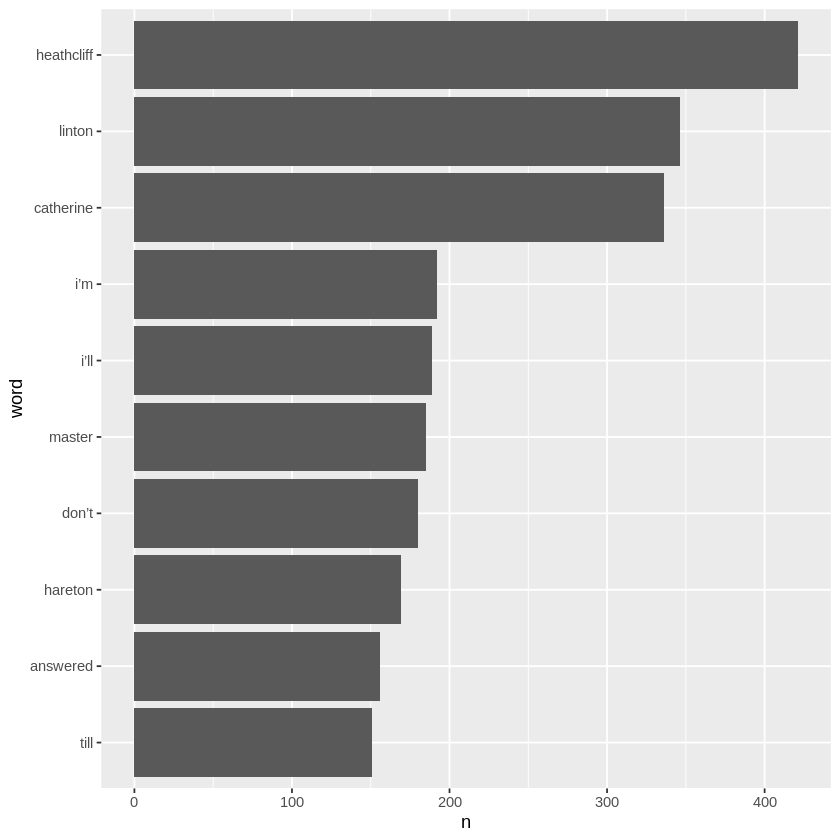

In [38]:
library(ggplot2)
threshold <- 150
freq <- relevant %>% count(word, sort = TRUE) 
head(freq)
top <- freq %>% filter (n > threshold) %>% mutate(word = reorder(word, n))
ggplot(data = top, aes(word, n)) + geom_col() + coord_flip() # horizontal bar chart

How about the document-term frequencies?

In [62]:
cf <- relevant %>% count(word, chapter) # frequencies of words per chapter
head(cf)
threshold <- 5 # now, mind you, this is a chapter-level threshold, whereas in Python we used a book-level one
fcf <- cf %>% filter(n > threshold) # a filtered version to keep the matrix small so we can browse it easily
head(fcf)

word,chapter,n
<chr>,<int>,<int>
_all_,13,1
_almost_,29,1
_almost_,34,1
_am_,9,1
_am_,24,1
_am_,27,1


word,chapter,n
<chr>,<int>,<int>
afraid,27,8
answer,11,7
answered,9,10
answered,10,9
answered,12,8
answered,17,7


In [44]:
install.packages("quanteda") # need another library for this
library(quanteda)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘ISOcodes’, ‘fastmatch’, ‘RcppParallel’, ‘stopwords’, ‘RcppArmadillo’


Package version: 3.2.1
Unicode version: 10.0
ICU version: 60.2

Parallel computing: 2 of 2 threads used.

See https://quanteda.io for tutorials and examples.



In [63]:
tdm <- fcf %>% cast_dfm(chapter, word, n)
tdm

Document-feature matrix of: 33 documents, 107 features (87.65% sparse) and 0 docvars.
    features
docs afraid answer answered bed bid book branderham called candle catherine
  27      8      0        7   0   0    0          0      0      0        33
  11      0      7        0   0   0    0          0      0      0        10
  9       0      0       10   0   0    0          0      0      0        19
  10      0      0        9   0   0    0          0      6      0        19
  12      0      0        8   8   0    0          0      0      0        11
  17      0      0        7   0   0    0          0      0      0        13
[ reached max_ndoc ... 27 more documents, reached max_nfeat ... 97 more features ]

And word clouds in R?

In [65]:
install.packages("quanteda.textplots") # yes, another library
library(quanteda.textplots) # check https://quanteda.io/articles/pkgdown/examples/plotting.html for more ideas

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘coda’, ‘extrafontdb’, ‘Rttf2pt1’, ‘statnet.common’, ‘extrafont’, ‘ggrepel’, ‘sna’, ‘igraph’, ‘network’




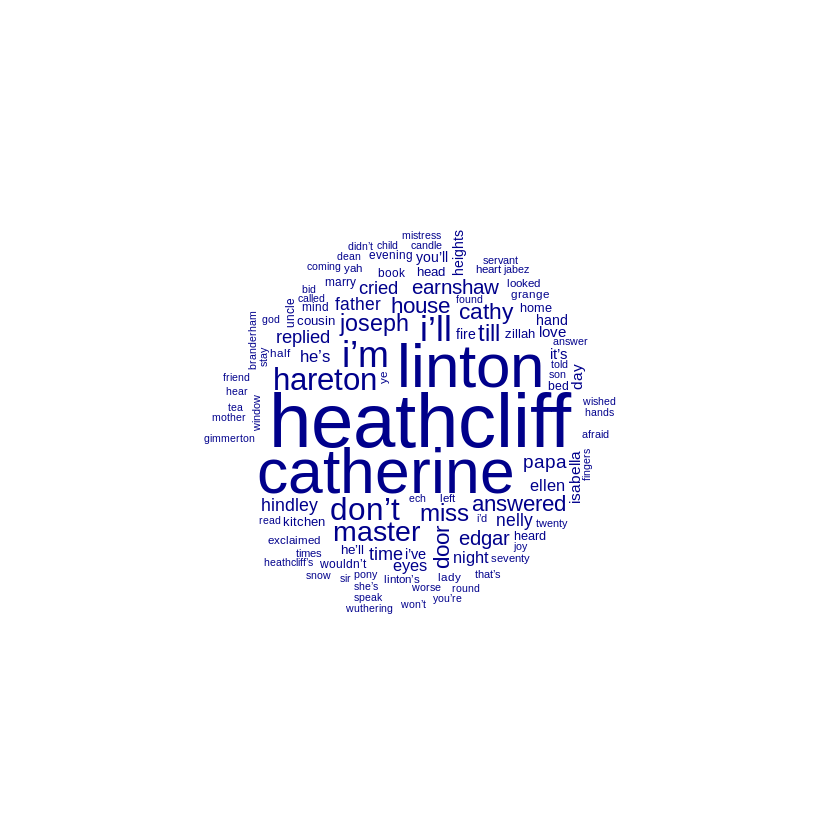

In [66]:
textplot_wordcloud(tdm)